In [8]:
def posterior_distribution(
        model_checkpoint: str,
        processed_dir: str = "processed_data",
        embeddings_npy: str = "embeddings.npy",
        filenames_npy: str  = "filenames.npy",
        n_rows: int       = 200,
        n_samples: int    = 600,
        random_state: int = 42,
        select_halo_ids: list = None,
        select_snapshots: list = None):
    """
    Same as plot_figure14, but conditions on BOTH observables (X.csv) 
    and representation‐space embeddings.
    """
    import os, re
    import numpy as np
    import pandas as pd
    import torch
    import joblib
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import train_test_split
    from model import cINN

    # 1) Load scaled observables + targets + meta + scalers
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_full  = dfX.values           # (N, D_obs)
    Y_full  = dfY.values           # (N, D_tar)
    obs_sc  = joblib.load(os.path.join(processed_dir, "obs_scaler.pkl"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape

    # 2) Recover the SAME test‐set split
    idx, idx_tmp = np.arange(N), None
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    val_frac         = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    X_test    = X_full[idx_test]
    Y_test    = Y_full[idx_test]
    meta_test = df_meta.iloc[idx_test].reset_index(drop=True)
    halo_ids     = meta_test["HaloID"].values
    snapshot_ids = meta_test["Snapshot"].values

    # 3) Build “prior” KDEs on each target in physical units
    Yp = tar_sc.inverse_transform(Y_test)
    priors = []
    for d in range(D_tar):
        data = Yp[:, d][:, None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:, None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # 4) Load & scale embeddings **for the test set**
    def normalize_fname(fname: str) -> str:
        base = os.path.splitext(os.path.basename(fname))[0]
        m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
        snap, halo = int(m.group(1)), int(m.group(2))
        return f"{halo}_{snap}"

    # 4a) Build key→embedding map
    all_emb    = np.load(embeddings_npy)    # (N_proj, D_emb)
    all_fnames = np.load(filenames_npy)     # (N_proj,)
    df_emb     = pd.DataFrame(all_emb)
    df_emb["key"] = [normalize_fname(f) for f in all_fnames]
    emb_map = {
        row["key"]: row.drop("key").values
        for _, row in df_emb.iterrows()
    }

    # 4b) Fetch embeddings in test‐set order
    missing, E_list = [], []
    for _, row in meta_test.iterrows():
        key = f"{int(row.HaloID)}_{int(row.Snapshot)}"
        emb = emb_map.get(key)
        if emb is None:
            missing.append(key)
        else:
            E_list.append(emb)
    if missing:
        raise KeyError("Missing embeddings for keys: " + ", ".join(missing))
    E_test_raw = np.vstack(E_list)        # (len(idx_test), D_emb)

    # 4c) Scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_test = emb_sc.transform(E_test_raw) # (len(idx_test), D_emb)

    # 5) Combine observables + embeddings into one condition matrix
    X_test_cond = np.hstack([X_test, E_test])  # (len(idx_test), D_obs + D_emb)
    D_obs_comb  = X_test_cond.shape[1]

    # 6) Load your trained cINN with the combined input‐dim
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(y_dim=D_tar, x_dim=D_obs_comb, hidden_dim=128, n_blocks=12, clamp=2.0)
    model  = model.to(device).eval()
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)

    # 7) Select which test rows to plot
    if select_halo_ids is not None and select_snapshots is not None:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("select_halo_ids and select_snapshots length mismatch")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            idxs = meta_test[
                (meta_test["HaloID"] == hid) &
                (meta_test["Snapshot"] == snap)
            ].index.tolist()
            if not idxs:
                raise ValueError(f"No test entry for HaloID={hid}, Snapshot={snap}")
            chosen.append(idxs[0])
        n_rows = len(chosen)
    else:
        rng    = np.random.RandomState(random_state)
        chosen = rng.choice(len(X_test_cond), size=n_rows, replace=False).tolist()

    # 8) Sample posteriors, compute MAPs & truths
    post_phys = np.zeros((n_rows, n_samples, D_tar))
    maps_phys = np.zeros((n_rows, D_tar))
    true_phys = np.zeros((n_rows, D_tar))

    for i_row, idx0 in enumerate(chosen):
        x0 = torch.tensor(
            X_test_cond[idx0:idx0+1],
            dtype=torch.float32,
            device=device
        )
        Z  = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv_out = model.inverse(Z, x0.repeat(n_samples, 1))
            Ys = inv_out[0] if isinstance(inv_out, tuple) else inv_out
        Ys = Ys.cpu().numpy()
        post_phys[i_row] = tar_sc.inverse_transform(Ys)

        # MAP via KDE
        for d in range(D_tar):
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            g2   = np.linspace(samp.min(), samp.max(), 200)[:, None]
            ld2  = kde2.score_samples(g2)
            maps_phys[i_row, d] = g2[np.argmax(np.exp(ld2)), 0]

        true_phys[i_row] = tar_sc.inverse_transform(Y_test[idx0:idx0+1])[0]

    # 9) Plot exactly as before
    target_labels = [
        'Time of Collision (Gyr)',
        'Velocity of Collision (km/s)',
        r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
        r'Subcluster mass ($10^{14} \, M_{\odot}$)',
        'Mass Ratio',
        'Pericenter distance (kpc)',
    ]
    fig, axes = plt.subplots(
        n_rows, D_tar,
        figsize=(3 * D_tar, 1.25 * n_rows),
        sharex="col", squeeze=False
    )

    for i_row, gal in enumerate(chosen):
        axes[i_row, 0].text(
            -0.12, 0.5,
            f"{snapshot_ids[gal]}\n{halo_ids[gal]}",
            transform=axes[i_row, 0].transAxes,
            va="center", ha="right", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[i_row, d]
            # PRIOR
            g_prior, pd_prior = priors[d]
            ax.fill_between(g_prior, pd_prior, color="lightgrey", alpha=0.6)
            ax.plot(g_prior, pd_prior, "k--", lw=1)
            # POSTERIOR
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:, None]
            pd_post = np.exp(kde2.score_samples(g_post))
            pd_post /= pd_post.max()
            ax.plot(g_post.ravel(), pd_post, color="C0", lw=2)
            # MAP & truth
            ax.axvline(maps_phys[i_row, d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row, d], color="red",  lw=1.5)
            ax.set_xlim(g_prior.min(), g_prior.max())
            if i_row == n_rows - 1:
                ticks = np.linspace(g_prior.min(), g_prior.max(), 5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks],
                                   fontsize=6, rotation=45)
            else:
                ax.set_xticks([])
            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)
            ax.set_yticks([])

    plt.tight_layout()
    #fig.savefig("1.posterior_distribution.pdf", bbox_inches="tight")
    fig.savefig("1.posterior_distribution.png", bbox_inches="tight")
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_47331/1433852524.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicit

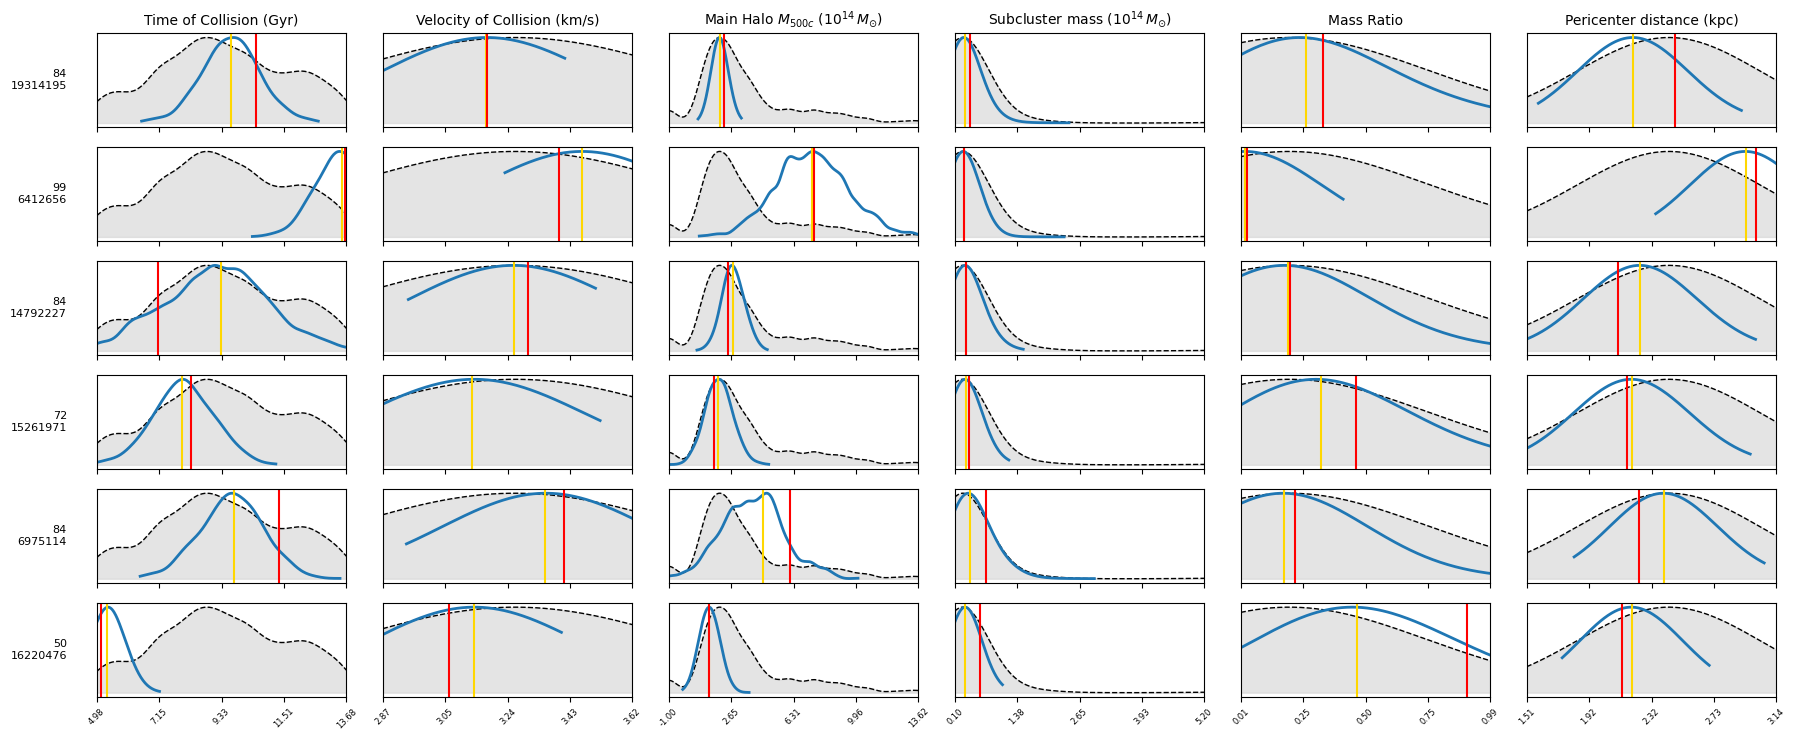

In [9]:
# plot by specifying exact galaxies:
#halo_ids    = [3655354, 18755555, 18640157, 10913474, 6775821, 3960854, 7117080
                #,19406945, 14397702, 1610308, 13826982, 16276166, 6921818, 18700555, 17022321]
#snapshots   = [50, 67, 59, 84, 72, 99, 72
               # , 78, 99, 99, 84, 99, 91, 91, 84]
posterior_distribution(
    model_checkpoint="best_cluster_cinn_combined.pt",
    processed_dir="processed_data",
    embeddings_npy="embeddings.npy",
    filenames_npy="filenames.npy",
    #select_halo_ids=halo_ids,
    #select_snapshots=snapshots,
    n_samples=1000,
    n_rows=6,
    random_state=6
)

# one working with trian_cluster_cinn_prohjections.py

In [10]:
def plot_figure14_combined(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    embeddings_npy: str = "embeddings.npy",
    filenames_npy: str  = "filenames.npy",
    n_rows: int       = 200,
    n_samples: int    = 600,
    random_state: int = 42,
    select_rows: list = None):
    """
    Plot posterior vs prior vs MAP vs truth for select projection‐instances
    (each halo×snapshot×proj is its own point), conditioning on BOTH
    observables (X.csv) and representation‐space embeddings.
    
    If select_rows is a list of integer test‐set indices (0 ≤ i < N_test),
    those rows will be plotted. Otherwise, n_rows random projections are chosen.
    """
    import os, re
    import numpy as np
    import pandas as pd
    import torch, joblib
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors  import KernelDensity
    import matplotlib.pyplot as plt
    from cluster_cinn import cINN

    # 1) Load halo‐level CSVs
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values    # (2183, D_obs)
    Y_all   = dfY.values    # (2183, D_tar)

    # map each halo_snapshot → row index
    halo_snap_to_idx = {
        f"{int(r.HaloID)}_{int(r.Snapshot)}": i
        for i, r in meta.iterrows()
    }

    # 2) Load ALL embeddings + filenames
    all_emb    = np.load(embeddings_npy)  # (N_proj_total, D_emb)
    all_files  = np.load(filenames_npy)   # (N_proj_total,)
    pattern    = re.compile(r"^snap_(\d+)_halo_(\d+)_proj_\d+$")

    proj_keys, E_proj_raw = [], []
    for fn, emb in zip(all_files, all_emb):
        base = os.path.splitext(fn)[0]
        m = pattern.match(base)
        snap, halo = m.group(1), m.group(2)
        key = f"{int(halo)}_{int(snap)}"
        if key in halo_snap_to_idx:
            proj_keys.append(key)
            E_proj_raw.append(emb)
    E_proj_raw = np.vstack(E_proj_raw)    # (6549, D_emb)

    # 3) Build projection‐level X_s and Y
    X_s_proj = np.vstack([ X_s_all[halo_snap_to_idx[k]] for k in proj_keys ])
    Y_proj   = np.vstack([   Y_all[halo_snap_to_idx[k]] for k in proj_keys ])

    # 4) Scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)  # (6549, D_emb)

    # 5) Combine and split into train/val/test
    X_all = np.hstack([X_s_proj, E_proj])  # (6549, D_obs + D_emb)
    Y_all = Y_proj                         # (6549, D_tar)

    N = X_all.shape[0]
    idx = np.arange(N)
    # 10% test
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    # 10% of remainder val
    val_frac = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    # explosion of print for confirmation
    print(f"Total projections: {N}, Test set size: {len(idx_test)}")

    # 6) Build priors on each target (physical units)
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    Yp = tar_sc.inverse_transform(Y_test)
    D_tar = Y_test.shape[1]
    priors = []
    for d in range(D_tar):
        data = Yp[:,d][:,None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:,None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # extract halo_ids & snapshots from keys_test
    halo_ids     = np.array([int(k.split("_")[0]) for k in keys_test])
    snapshot_ids = np.array([int(k.split("_")[1]) for k in keys_test])

    # 7) Choose which test‐rows to plot
    if select_rows is not None:
        chosen = select_rows
    else:
        rng = np.random.RandomState(random_state)
        chosen = rng.choice(len(idx_test), size=min(n_rows, len(idx_test)), replace=False).tolist()
    n_rows = len(chosen)

    # prepare storage
    post_phys = np.zeros((n_rows, n_samples, D_tar))
    maps_phys = np.zeros((n_rows, D_tar))
    true_phys = np.zeros((n_rows, D_tar))

    # 8) Load model
    D_obs_comb = X_all.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(y_dim=D_tar, x_dim=D_obs_comb, hidden_dim=128, n_blocks=12, clamp=2.0)
    model  = model.to(device).eval()
    state  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(state)

    # 9) Sample posteriors & compute MAP/truth
    for i_row, test_i in enumerate(chosen):
        x0 = torch.tensor(X_test[test_i:test_i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_samples,1))
            Ys  = inv[0] if isinstance(inv, tuple) else inv
        Ys = Ys.cpu().numpy()
        post_phys[i_row] = tar_sc.inverse_transform(Ys)

        # MAP via KDE
        for d in range(D_tar):
            samp = post_phys[i_row,:,d][:,None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            grid = np.linspace(samp.min(), samp.max(), 200)[:,None]
            ld   = kde2.score_samples(grid)
            maps_phys[i_row,d] = grid[np.argmax(np.exp(ld)),0]

        true_phys[i_row] = tar_sc.inverse_transform(Y_test[test_i:test_i+1])[0]

    # 10) Plot grid
    target_labels = list(dfY.columns)
    fig, axes = plt.subplots(n_rows, D_tar,
                             figsize=(3*D_tar, 1.25*n_rows),
                             sharex="col", squeeze=False)
    for i_row, test_i in enumerate(chosen):
        axes[i_row,0].text(-0.12, 0.5,
            f"{snapshot_ids[test_i]}\n{halo_ids[test_i]}",
            transform=axes[i_row,0].transAxes,
            va="center", ha="right", fontsize=8)
        for d in range(D_tar):
            ax = axes[i_row,d]
            # PRIOR
            g_p, p_p = priors[d]
            ax.fill_between(g_p, p_p, color="lightgrey", alpha=0.6)
            ax.plot(g_p, p_p, "k--", lw=1)
            # POSTERIOR
            samp   = post_phys[i_row,:,d][:,None]
            kde3   = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:,None]
            p_post = np.exp(kde3.score_samples(g_post))
            p_post /= p_post.max()
            ax.plot(g_post.ravel(), p_post, color="C0", lw=2)
            # MAP & truth lines
            ax.axvline(maps_phys[i_row,d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row,d], color="red",  lw=1.5)
            ax.set_xlim(g_p.min(), g_p.max())
            if i_row == n_rows-1:
                ticks = np.linspace(g_p.min(), g_p.max(), 5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks],
                                    fontsize=6, rotation=45)
            else:
                ax.set_xticks([])
            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)
            ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("figure14_combined.pdf", bbox_inches="tight")
    plt.savefig("figure14_combined.png", bbox_inches="tight")
    plt.show()


Total projections: 6549, Test set size: 655


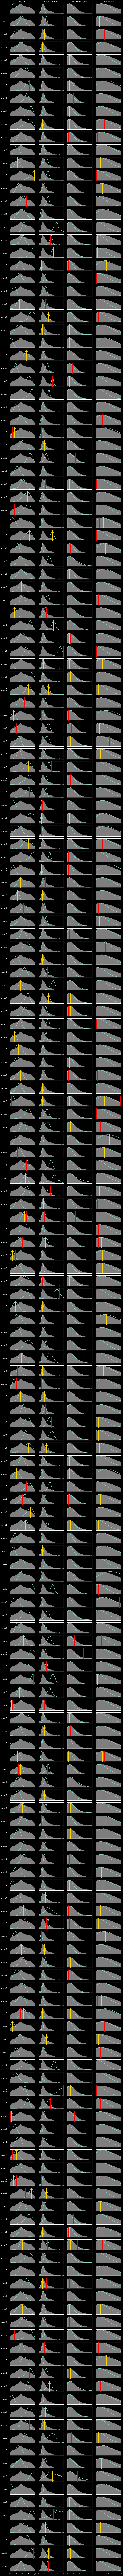

In [2]:
plot_figure14_combined(
    model_checkpoint="best_cluster_cinn_combined.pt",
    processed_dir="processed_data",
    embeddings_npy="embeddings.npy",
    filenames_npy="filenames.npy",
    n_rows=200,
    n_samples=600,
    random_state=42
)

In [22]:
def plot_figure14_combined(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    embeddings_npy: str = "embeddings.npy",
    filenames_npy: str  = "filenames.npy",
    n_rows: int       = 200,
    n_samples: int    = 600,
    random_state: int = 42,
    select_halo_ids: list = None,
    select_snapshots: list = None):
    """
    Plot posterior vs prior vs MAP vs truth for projection‐instances,
    conditioning on BOTH observables and embeddings.
    
    If select_halo_ids & select_snapshots are provided (same length),
    for each pair we'll randomly choose one of the 3 projections for that
    halo‐snapshot in the TEST set. Otherwise we pick `n_rows` random tests.
    """
    import os, re
    import numpy as np
    import pandas as pd
    import torch, joblib
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors  import KernelDensity
    import matplotlib.pyplot as plt
    from cluster_cinn import cINN

    # 1) Load halo‐level CSVs
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values    # (2183, D_obs)
    Y_all   = dfY.values    # (2183, D_tar)

    # map halo_snapshot → row index
    halo_snap_to_idx = {
        f"{int(r.HaloID)}_{int(r.Snapshot)}": i
        for i, r in meta.iterrows()
    }

    # 2) Load all embeddings + filenames & parse keys
    all_emb   = np.load(embeddings_npy)   # (6549, D_emb)
    all_files = np.load(filenames_npy)    # (6549,)
    pattern   = re.compile(r"^snap_(\d+)_halo_(\d+)_proj_\d+$")

    proj_keys, E_proj_raw = [], []
    for fn, emb in zip(all_files, all_emb):
        base = os.path.splitext(fn)[0]
        m    = pattern.match(base)
        snap, halo = m.group(1), m.group(2)
        key = f"{int(halo)}_{int(snap)}"
        if key in halo_snap_to_idx:
            proj_keys.append(key)
            E_proj_raw.append(emb)
    E_proj_raw = np.vstack(E_proj_raw)    # (6549, D_emb)

    # 3) Build projection‐level X_s and Y
    X_s_proj = np.vstack([ X_s_all[halo_snap_to_idx[k]] for k in proj_keys ])
    Y_proj   = np.vstack([   Y_all[halo_snap_to_idx[k]] for k in proj_keys ])

    # 4) Scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)  # (6549, D_emb)

    # 5) Combine & split into train/val/test
    X_all = np.hstack([X_s_proj, E_proj])  # (6549, D_obs+D_emb)
    Y_all = Y_proj                         # (6549, D_tar)

    N = X_all.shape[0]
    idx = np.arange(N)
    idx_tmp, idx_test  = train_test_split(idx, test_size=0.1, random_state=random_state)
    idx_train, idx_val = train_test_split(idx_tmp, test_size=0.1/0.9, random_state=random_state)

    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    # 6) Build priors on Y_test (physical units)
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    Yp     = tar_sc.inverse_transform(Y_test)
    D_tar  = Y_test.shape[1]
    priors = []
    for d in range(D_tar):
        data = Yp[:,d][:,None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:,None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # extract halo_ids & snapshot_ids arrays
    halo_ids     = np.array([int(k.split("_")[0]) for k in keys_test])
    snapshot_ids = np.array([int(k.split("_")[1]) for k in keys_test])

    # 7) Choose test indices to plot
    rng = np.random.RandomState(random_state)
    if select_halo_ids is not None and select_snapshots is not None:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("select_halo_ids and select_snapshots must match in length")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            # find all projections in test with that halo&snap
            mask = (halo_ids==hid)&(snapshot_ids==snap)
            idxs = np.where(mask)[0]
            if len(idxs)==0:
                raise ValueError(f"No test projections found for {hid}_{snap}")
            # pick one projection at random
            pick = rng.choice(idxs)
            chosen.append(pick)
    else:
        chosen = rng.choice(len(X_test), size=min(n_rows, len(X_test)), replace=False).tolist()

    n_rows = len(chosen)

    # 8) Load model
    D_cond = X_all.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(y_dim=D_tar, x_dim=D_cond, hidden_dim=128, n_blocks=12, clamp=2.0)
    model  = model.to(device).eval()
    state  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(state)

    # 9) Sample posteriors & compute MAP/truth
    post_phys = np.zeros((n_rows, n_samples, D_tar))
    maps_phys = np.zeros((n_rows, D_tar))
    true_phys = np.zeros((n_rows, D_tar))

    for i_row, test_i in enumerate(chosen):
        x0 = torch.tensor(X_test[test_i:test_i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_samples,1))
            Ys  = inv[0] if isinstance(inv, tuple) else inv
        Ys = Ys.cpu().numpy()
        post_phys[i_row] = tar_sc.inverse_transform(Ys)

        for d in range(D_tar):
            samp = post_phys[i_row,:,d][:,None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            g2   = np.linspace(samp.min(), samp.max(), 200)[:,None]
            maps_phys[i_row,d] = g2[np.argmax(np.exp(kde2.score_samples(g2))),0]

        true_phys[i_row] = tar_sc.inverse_transform(Y_test[test_i:test_i+1])[0]

    # 10) Plot grid (same as before)
    target_labels = list(dfY.columns)
    fig, axes = plt.subplots(n_rows, D_tar,
                             figsize=(3*D_tar, 1.25*n_rows),
                             sharex="col", squeeze=False)
    for i_row, test_i in enumerate(chosen):
        axes[i_row,0].text(-0.12,0.5,
            f"{snapshot_ids[test_i]}\n{halo_ids[test_i]}",
            transform=axes[i_row,0].transAxes,
            va="center", ha="right", fontsize=8)
        for d in range(D_tar):
            ax = axes[i_row,d]
            g_p, p_p = priors[d]
            ax.fill_between(g_p, p_p, color="lightgrey", alpha=0.6)
            ax.plot(g_p, p_p, "k--", lw=1)

            samp   = post_phys[i_row,:,d][:,None]
            kde3   = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:,None]
            p_post = np.exp(kde3.score_samples(g_post))
            p_post /= p_post.max()
            ax.plot(g_post.ravel(), p_post, color="C0", lw=2)

            ax.axvline(maps_phys[i_row,d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row,d], color="red",  lw=1.5)
            ax.set_xlim(g_p.min(), g_p.max())

            if i_row == n_rows-1:
                ticks = np.linspace(g_p.min(), g_p.max(), 5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=6, rotation=45)
            else:
                ax.set_xticks([])

            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)

            ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [24]:
# plot by specifying exact galaxies:
halo_ids    = [12274768, 14397702, 16831981, 14034933, 10250314, 14781744, 7895542
                ,16617127, 1791552, 12274768, 18938111, 11419483, 7308175, 14768508, 7308175]
snapshots   = [99, 99, 67, 84, 84, 72, 67
                , 59, 84, 99, 84, 91, 50, 67, 50]
plot_figure14_combined(
    model_checkpoint="best_cluster_cinn_combined.pt",
    processed_dir="processed_data",
    embeddings_npy="embeddings.npy",
    filenames_npy="filenames.npy",
    select_halo_ids=halo_ids,
    select_snapshots=snapshots,
    n_samples=200
)

ValueError: No test projections found for 12274768_99

Total projections: 6549, Test set size: 655


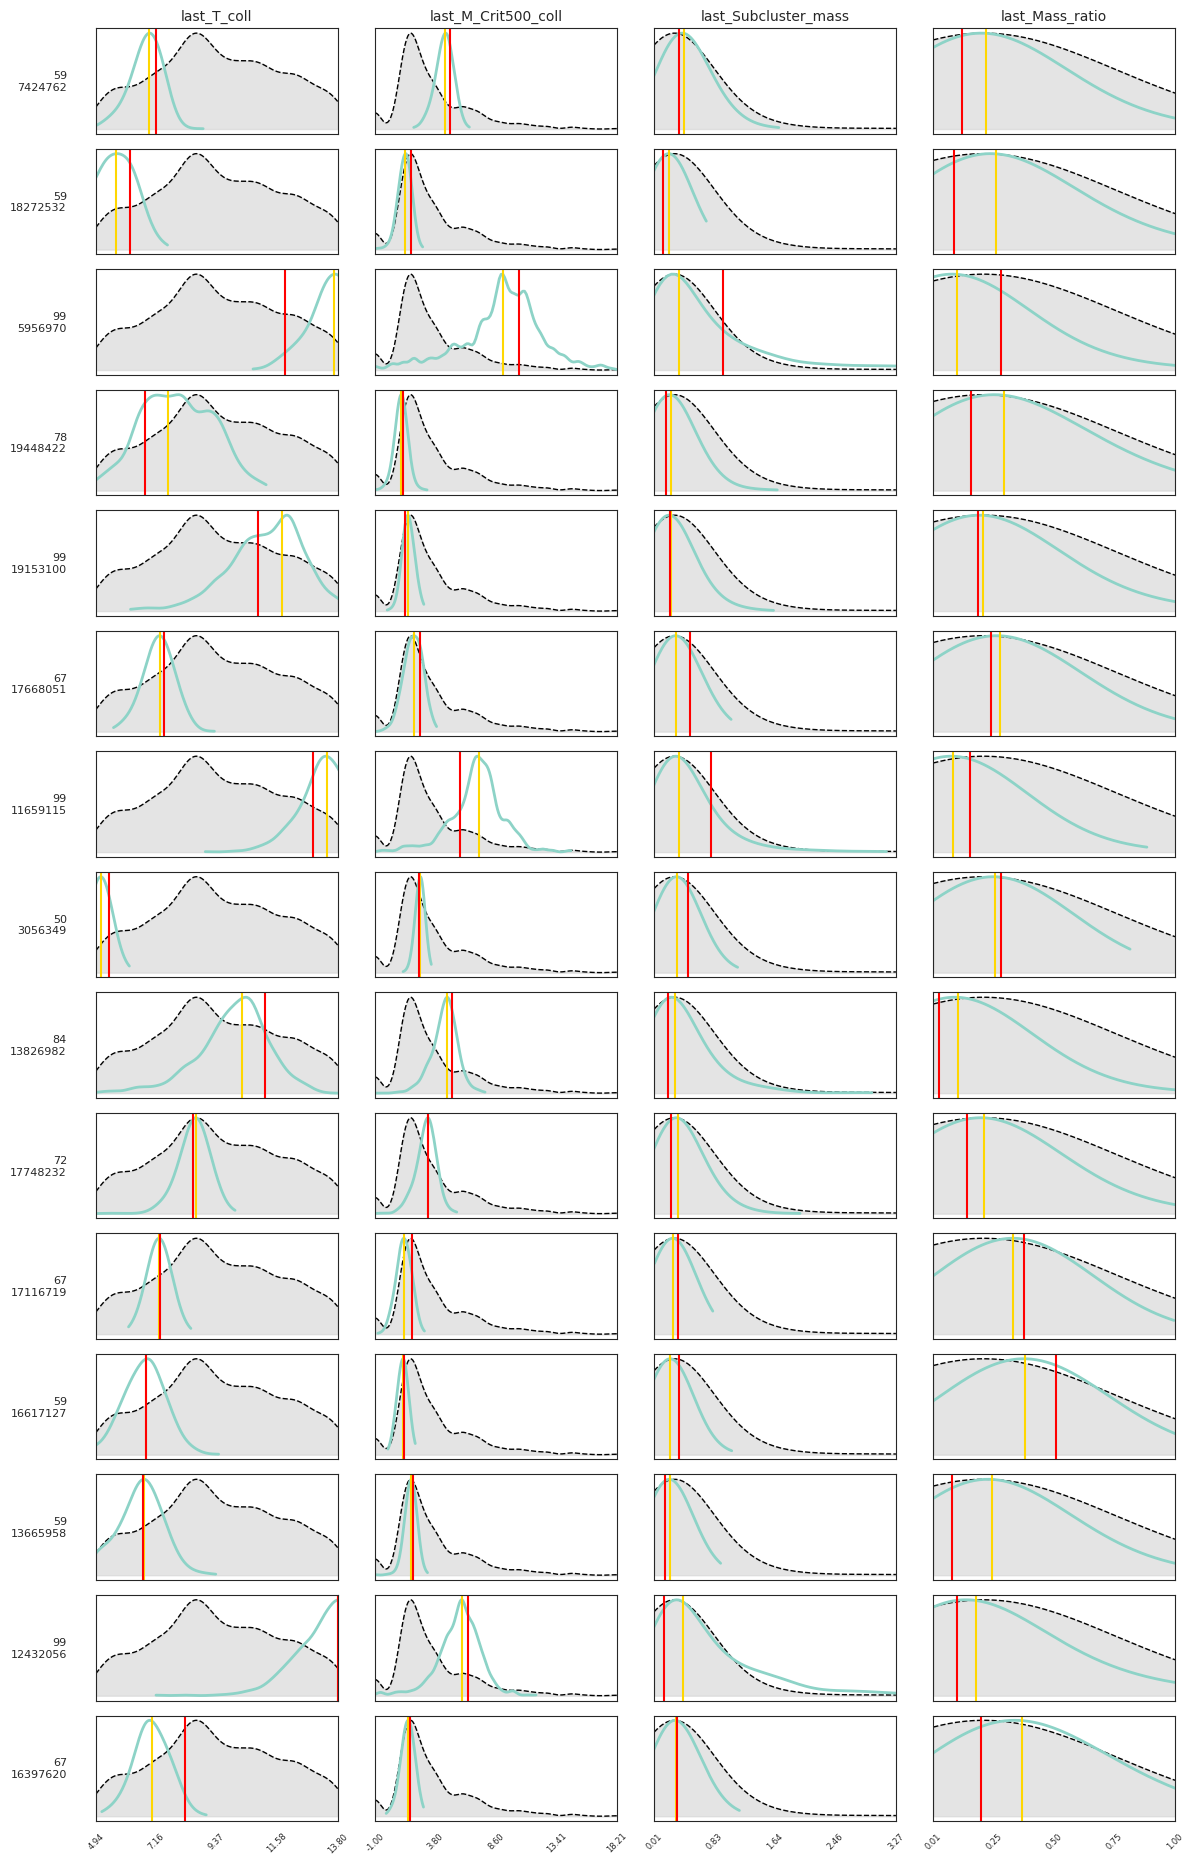

In [12]:
import seaborn as sns  
sns.set_style("white")
plot_figure14_combined(
    model_checkpoint="best_cluster_cinn_combined.pt",
    processed_dir="processed_data",
    embeddings_npy="embeddings.npy",
    filenames_npy="filenames.npy",
    n_rows=15,
    n_samples=600,
    random_state=22
)
